In [171]:
# For handeling DataFrame
import pandas as pd
import numpy as np

#For plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# For dividing Train and test set
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#For Feature Scalling
from sklearn.preprocessing import MinMaxScaler

# For Tree(CART)
from sklearn.tree import DecisionTreeRegressor

# For building models
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

import sklearn
import matplotlib

In [172]:
## For evaluating the matrix
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

# Data display no. of columns
pd.set_option('display.max_columns', 150)

## Ignore the warnings
import warnings
warnings.filterwarnings('ignore')


In [275]:
print(f'pandas version:  {pd.__version__}')
print(f'numpy version:   {np.__version__}')
print(f'matplotlib version: {matplotlib.__version__}')
print(f'seaborn version: {sns.__version__}')
print(f'sklearn version: {sklearn.__version__}')

pandas version:  0.23.4
numpy version:   1.16.1
matplotlib version: 3.0.2
seaborn version: 0.9.0
sklearn version: 0.20.1


In [174]:
## Load the dataset

df = pd.read_csv('../PasarPolis/predict_sales.csv')

In [175]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [176]:
# Lets check the identifier column
print(f'The number of unique values in Item_Identifier column is {df["Item_Identifier"].nunique()} and total length of dataframe is {df.shape[0]} ')

The number of unique values in Item_Identifier column is 1559 and total length of dataframe is 8523 


## Temporal Data

In [177]:
# Find the temporal data
temporal_var = [i for i in df.columns if 'Year' in i]
temporal_var

['Outlet_Establishment_Year']

Text(0.5, 0, 'Years')

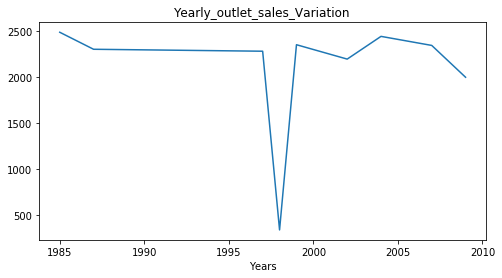

In [178]:
plt.figure(figsize= (8,4))
df.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].mean().plot()
plt.title('Yearly_outlet_sales_Variation')
plt.xlabel('Years')

Text(0.5, 0, 'Years')

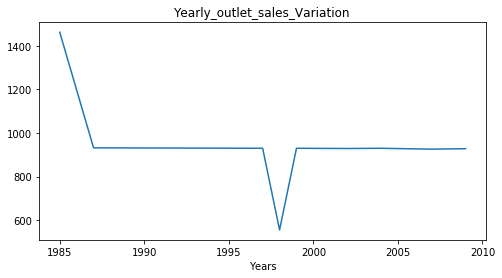

In [179]:
plt.figure(figsize= (8,4))
df.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].count().plot()
plt.title('Yearly_outlet_sales_Variation')
plt.xlabel('Years')

In [180]:
df.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].agg(['count', 'mean'])

,count,mean
Outlet_Establishment_Year,,
1985,1463,2483.677474
1987,932,2298.995256
1997,930,2277.844267
1998,555,339.351662
1999,930,2348.354635
2002,929,2192.384798
2004,930,2438.841866
2007,926,2340.675263
2009,928,1995.498739


We see that the observation for year 1998 is very less, almost half w.r.t other years and as a result the sales is very less Othet years sales are almost 21 times as that of 1998

## Numerical variable

In [181]:
df_numerical = df.select_dtypes(exclude='O')

df_numerical.drop(columns = 'Outlet_Establishment_Year', axis=1, inplace=True) # drop temporal data

df_numerical.columns

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales'], dtype='object')

### Discrete Variable

In [182]:
### Discrete variable
Discrete = []
for col in ['Item_Weight', 'Item_Visibility', 'Item_MRP']:
    if len(df[col].unique())<30:
        print(col)
        Discrete.append(col)
if len(Discrete) ==0:
    print('There are no discrete variables')

There are no discrete variables


## Categorical variables

In [183]:
len(df.select_dtypes(include='O').columns)

7

    Number of Numerical variables = 3 (Excluding 1 Target variable)
    Number of Discrete variables = 0
    Number of Temporal variables = 1
    Number of categorical variable = 7

### Type of problem with variables
1. Spelling or abbreviations
2. Missing 
3. Outliers
4. Rare categorical values
5. High Cardianility

### 1. Spelling and abbreviations

Spellings are associated with categorical variable only

In [184]:
df_categorical = df.select_dtypes(include='O')

num_of_labels =[]
for var in df_categorical:
    #print(len(df[var].unique()))
    num_of_labels.append(len(df[var].unique()))

Text(0, 0.5, 'Count of different category')

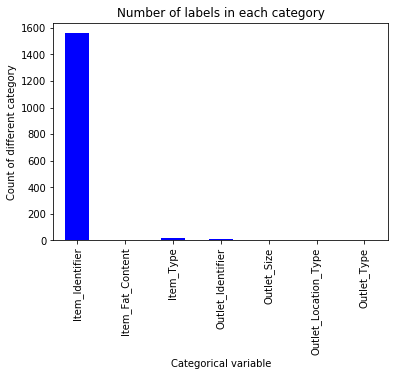

In [185]:
category = pd.Series(num_of_labels)
category.index = df_categorical.columns

category.plot(kind='bar', color = 'b' )
plt.title('Number of labels in each category')
plt.xlabel('Categorical variable')
plt.ylabel('Count of different category')

(0, 30)

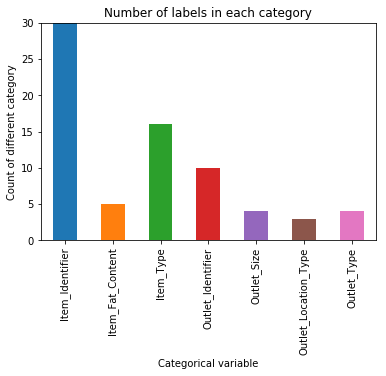

In [186]:
## Changing the ylimit for viewing the other variables
category.plot(kind='bar' )
plt.title('Number of labels in each category')
plt.xlabel('Categorical variable')
plt.ylabel('Count of different category')
plt.ylim(0,30)

In [187]:
for col in df_categorical.columns:
    print(f'{df[col].nunique(): <{5}} {col}')

1559  Item_Identifier
5     Item_Fat_Content
16    Item_Type
10    Outlet_Identifier
3     Outlet_Size
3     Outlet_Location_Type
4     Outlet_Type


Item_Identifier is a variable with High cardianalaty, rest all appears to be good

In [188]:
# Item_fat_content
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [189]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')

In [190]:
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

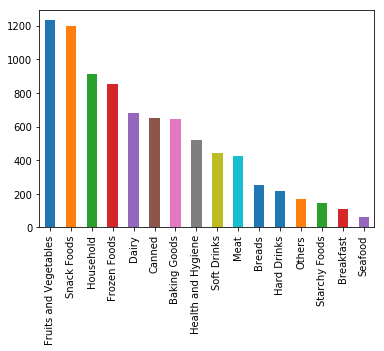

In [191]:
# Item_Type
df['Item_Type'].value_counts().plot(kind='bar')

In [192]:
df['Outlet_Identifier'].value_counts()

OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

Here we see OUT0 if removed, this variable cab be treated as a predictor, and can show correlation with other variables

In [193]:
df['Outlet_Identifier'] = df['Outlet_Identifier'].str.split('OUT0').str[1]

In [194]:
df['Outlet_Identifier'].value_counts()

27    935
13    932
35    930
49    930
46    930
45    929
18    928
17    926
10    555
19    528
Name: Outlet_Identifier, dtype: int64

In [195]:
df['Outlet_Size'].value_counts(dropna=False)

Medium    2793
NaN       2410
Small     2388
High       932
Name: Outlet_Size, dtype: int64

There is a good amount of missing values, but there are no spelling errors

In [196]:
df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [197]:
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

## 2. Missing Data

In [198]:
## Check for missing variables

missing_col = [i for i in df.columns if df[i].isnull().sum()>1]
missing_col

['Item_Weight', 'Outlet_Size']

In [199]:
#There are two variables, with missing values

df[missing_col].isnull().mean()

Item_Weight    0.171653
Outlet_Size    0.282764
dtype: float64

#### Missing value of numerical variable

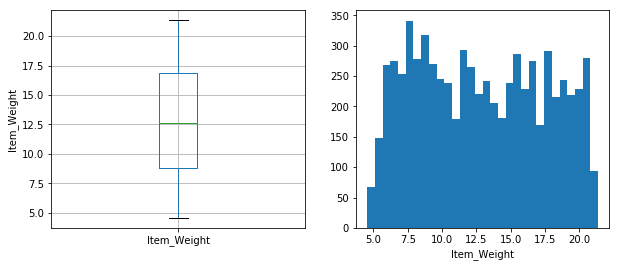

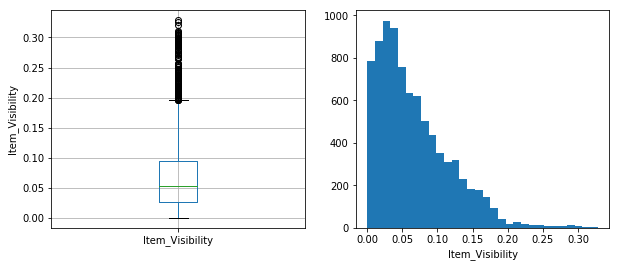

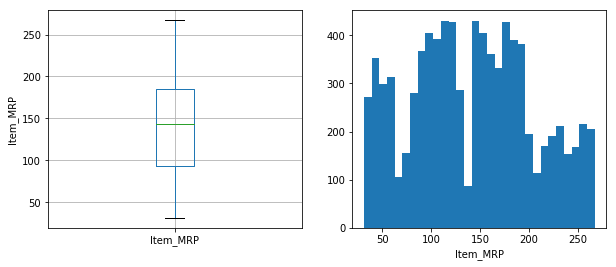

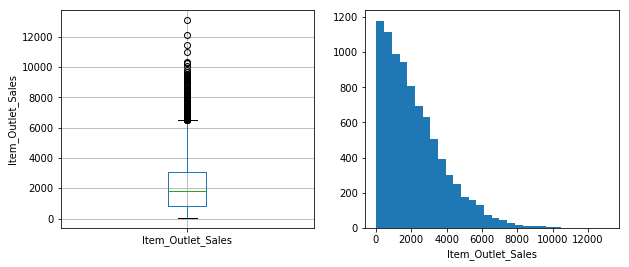

In [200]:
for col in df_numerical:
    plt.figure(figsize= (10,4))
    
    plt.subplot(1,2,1)
    fig = df.boxplot(column=col)
    fig.set_title('')
    fig.set_ylabel(col)
    
    plt.subplot(1,2,2)
    fig = df[col].plot(kind='hist', bins=30)
    fig.set_ylabel('')
    fig.set_xlabel(col)

1. Item weight  :- is uniformally distributed, if this variable is not contributing to target variable, we may drop it in Feature selection

2. Item Visibility :- It has outliers and is skewed, should be transformed

3. Item MRP :- This variable also shows very less variability

4. Item outlet sales : Skewed same as  Item visibility

Note :After transformation Standardization is also needed, I am avoiding normalization as outliers has a impact on normalization.

## EDA

In [201]:
df_numerical.describe()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,2181.288914
std,4.643456,0.051598,62.275067,1706.499616
min,4.555000,0.000000,31.290000,33.290000
25%,8.773750,0.026989,93.826500,834.247400
50%,12.600000,0.053931,143.012800,1794.331000
75%,16.850000,0.094585,185.643700,3101.296400
max,21.350000,0.328391,266.888400,13086.964800


We see that all the variables are on different scale, we must standarize them

In [202]:
scaler = MinMaxScaler()
df_numerical_normalize = scaler.fit_transform(df_numerical)

In [203]:
df_numerical_normalize ## Returns a array, we must convert it into a dataframe

array([[0.28252456, 0.04886645, 0.92750715, 0.28358666],
       [0.08127419, 0.05870508, 0.0720684 , 0.03141895],
       [0.77076511, 0.05103696, 0.46828841, 0.15811486],
       ...,
       [0.35992855, 0.10714751, 0.22849221, 0.08885035],
       [0.15808276, 0.44221878, 0.30493925, 0.13883505],
       [0.61000298, 0.13666114, 0.18750976, 0.05610527]])

In [204]:
df_numerical_normalize = pd.DataFrame(df_numerical_normalize, columns= [df_numerical.columns])

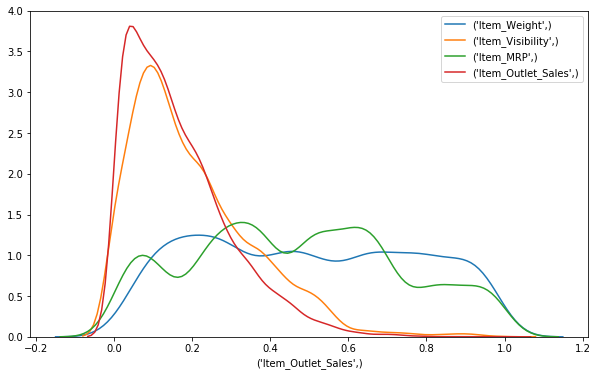

In [205]:
plt.figure(figsize= (10,6))
for col in df_numerical_normalize.columns:
    sns.distplot(df_numerical_normalize[col], hist=False, label=col)

Item visibility is high then sales is also high, Item MRP, and Item weight almost evenly distributed

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

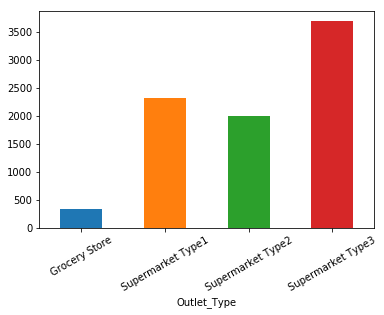

In [206]:
df.groupby('Outlet_Type')['Item_Outlet_Sales'].mean().plot(kind='bar')
plt.xticks(rotation=30)



(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

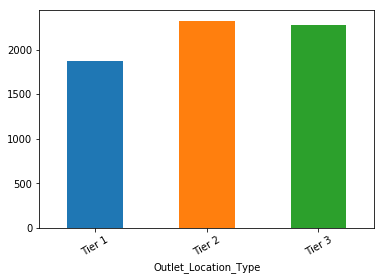

In [207]:
df.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean().plot(kind='bar')
plt.xticks(rotation=30)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

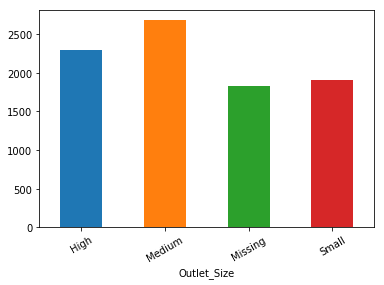

In [208]:
## Outlet size has missing values, filled it with a new category "Missing"

df.groupby(df['Outlet_Size'].fillna('Missing'))['Item_Outlet_Sales'].mean().plot(kind='bar')
plt.xticks(rotation=30)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

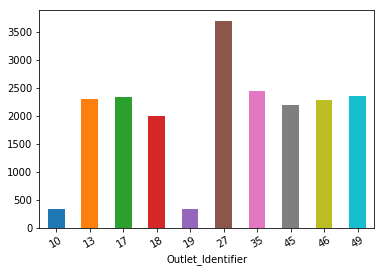

In [209]:
df.groupby('Outlet_Identifier')['Item_Outlet_Sales'].mean().plot(kind='bar')
plt.xticks(rotation=30)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

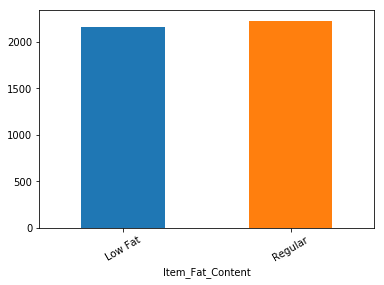

In [210]:
df.groupby('Item_Fat_Content')['Item_Outlet_Sales'].mean().plot(kind='bar')
plt.xticks(rotation=30)

Supermarket type 3, and outlet_Identifier 27 contributes highly in sales, where as medium size store is shows slightly high sales, when compared to other outlet_sizes 

# Feature Engineering

In [211]:
df_new = df.copy()

### Checkpoint

In [212]:
# Item identifier shows high cardinality, so for now lets drop it

In [213]:
df.drop('Item_Identifier', axis=1, inplace=True)

In [214]:
X = df.drop('Item_Outlet_Sales', axis=1)
y = df['Item_Outlet_Sales']

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state= 100)

X_train.shape, X_test.shape

((7670, 10), (853, 10))

In [216]:
#### Engineering missing data of numerical variable

In [217]:
X_train['Item_Weight'].isnull().mean()

0.17170795306388525

In [218]:
# Let us create a new variable to capture the missingness of data
# Item_Weight - 17 % of the data is missing
# Lets assume missing data is at random
# For knowing thedata is missing at random or not we must know how the data was collected.

In [219]:
# Create a new dataset to undestand the missingness
missing_item_wt = df[df['Item_Weight'].isnull()]

In [220]:
for col in missing_item_wt.columns:
    print(f'Unique values in {col: <{25}} = {missing_item_wt[col].nunique()}')

Unique values in Item_Weight               = 0
Unique values in Item_Fat_Content          = 2
Unique values in Item_Visibility           = 1362
Unique values in Item_Type                 = 16
Unique values in Item_MRP                  = 1371
Unique values in Outlet_Identifier         = 2
Unique values in Outlet_Establishment_Year = 1
Unique values in Outlet_Size               = 2
Unique values in Outlet_Location_Type      = 2
Unique values in Outlet_Type               = 2
Unique values in Item_Outlet_Sales         = 1183


In [221]:
# Outlet_Establishment_Year has only one value i.e data is missing only for one particular year

missing_item_wt['Outlet_Establishment_Year'].value_counts()


1985    1463
Name: Outlet_Establishment_Year, dtype: int64

    Outlet_Establishment_Year shows only one unique value, i.e. in 1985 there were no system of weighing the food item
    But this information does not add a value to out prediction

In [222]:
## Imputation of variable with mean or median
# Its skewed so we go for median imputation, 
# if it would be a normal distribution we would have done mean imputation

for df in [X_train, X_test]:
    df['Item_Weight'+'_NA'] = np.where(df['Item_Weight'].isnull(), 1,0) # New variable to capture the missingness
    df['Item_Weight'].fillna(X_train['Item_Weight'].median(), inplace=True) 

In [223]:
X_train.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Weight_NA
5885,20.2,Low Fat,0.000000,Household,187.1898,13,1987,High,Tier 3,Supermarket Type1,0
4478,12.6,Low Fat,0.040748,Snack Foods,140.2496,27,1985,Medium,Tier 3,Supermarket Type3,1
6694,20.1,Low Fat,0.075049,Dairy,110.4228,17,2007,NaN,Tier 2,Supermarket Type1,0


### Engineering missing data from Categorival variable

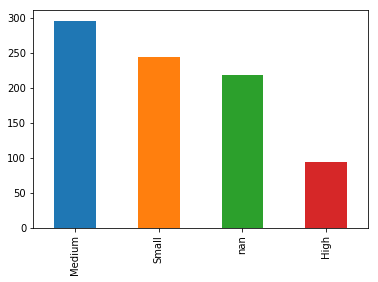

In [224]:
df['Outlet_Size'].value_counts(dropna=False).plot(kind='bar')

Store size High can be termed as a rare label, but I replace the nan with 'Missing' and create a new variable to capture missingness

In [225]:
## Adding a variable to capture NA

def impute_na_var(df_train, df_test, variable):
    # add additional variable to indicate missingness
    df_train[variable+'_missingness'] = np.where(df_train[variable].isnull(), 1, 0)
    df_test[variable+'_missingness'] = np.where(df_test[variable].isnull(), 1, 0)

In [226]:
## Adding a category "Missing" to capture NA
def impute_na_cat(df_train, df_test, variable):
    df_train[variable+'_NA'] = np.where(df_train[variable].isnull(), 'Missing', df_train[variable])
    df_test[variable+'_NA'] = np.where(df_test[variable].isnull(), 'Missing', df_test[variable])

In [227]:
impute_na_var(X_train, X_test,'Outlet_Size' ) ## Creating new variable
impute_na_cat(X_train, X_test, 'Outlet_Size') ## Replacing NAN with "Missing"

In [228]:
X_train.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Weight_NA,Outlet_Size_missingness,Outlet_Size_NA
5885,20.2,Low Fat,0.000000,Household,187.1898,13,1987,High,Tier 3,Supermarket Type1,0,0,High
4478,12.6,Low Fat,0.040748,Snack Foods,140.2496,27,1985,Medium,Tier 3,Supermarket Type3,1,0,Medium
6694,20.1,Low Fat,0.075049,Dairy,110.4228,17,2007,NaN,Tier 2,Supermarket Type1,0,1,Missing


In [229]:
### Engineering outliers of numerical variables

    We can go for "Top encoding" and "bottom encoding"
    As mean and variance are very sensitive to outliers, and also
    Some machine learning algorithms are very sensetive to outliers Like Linear regression, Ada Boost and k-means
    and their performance could be impaired, 
    thus I will engineer the features to minimize the impact of outliers on ML models.

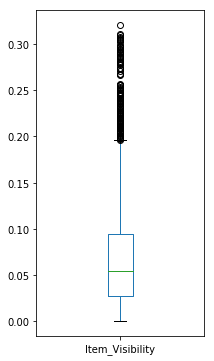

In [230]:
X_train['Item_Visibility'].plot.box(figsize=(3,6))

In this scenario Top encoding is needed

In [231]:
X_train['Item_Visibility'].describe()

count    7670.000000
mean        0.066095
std         0.051326
min         0.000000
25%         0.027058
50%         0.054129
75%         0.094548
max         0.321115
Name: Item_Visibility, dtype: float64

In [232]:
## Top encoding: upper boundary for outliers

IQR = X_train.Item_Visibility.quantile(0.75) - X_train.Item_Visibility.quantile(0.25)
IQR

0.0674899185

In [233]:
upper_boundary = X_train.Item_Visibility.quantile(0.75) + (IQR * 3)
upper_boundary

0.2970180395

In [234]:
X_train['Item_Visibility_engg'] = X_train['Item_Visibility']

In [235]:
X_test['Item_Visibility_engg'] = X_test['Item_Visibility']

In [236]:
X_train.loc[X_train['Item_Visibility_engg'] > 0.29, 'Item_Visibility'] = 0.29

In [237]:
X_test.loc[X_test['Item_Visibility_engg'] > 0.29, 'Item_Visibility'] = 0.29

In [238]:
X_train.shape, X_test.shape

((7670, 14), (853, 14))

## Encoding categorical variables

In [239]:
categorical_column = X_train.select_dtypes('O').columns

Lets drop Outlet_Size, Item_Visibility these two variables and create dummy variables

In [240]:
X_train.drop(['Outlet_Size','Item_Visibility'], axis=1, inplace=True)
X_test.drop(['Outlet_Size','Item_Visibility'], axis=1, inplace=True)

In [241]:
categorical_column =X_train.select_dtypes('O').columns

In [242]:
X_train_dummy = pd.get_dummies(X_train, 
                               columns= categorical_column,
                              drop_first=True)

X_test_dummy = pd.get_dummies(X_test, 
                              columns= categorical_column,
                              drop_first=True)

In [243]:
X_train_dummy.shape, X_test_dummy.shape

((7670, 39), (853, 39))

## Scaler

In [244]:
# fit scaler


scaler = MinMaxScaler() # create an instance
scaler.fit(X_train_dummy) #  fit  the scaler to the train set for later use
# Not selecting Year as its a correlated variable, which can be removed

MinMaxScaler(copy=True, feature_range=(0, 1))

In [245]:
scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

## Building Machine Learning Models

As seen earlier the Target variable is also skewed, so log transformation on Target would be great idea

Then, we must convert it back to its original sales value, to evaluate the model

#### XGBOOST

In [246]:
xgb_model = xgb.XGBRegressor()

evaluation_set = [(X_test_dummy, np.log(y_test))]

xgb_model.fit(X_train_dummy, np.log(y_train), eval_set = evaluation_set, verbose=False)

pred = xgb_model.predict(X_train_dummy)

## Training set
print('xgb train mse : {}'.format(mean_squared_error(y_train, np.exp(pred))))
print('xgb train rmse : {}'.format(sqrt(mean_squared_error(y_train, np.exp(pred)))))
print('xgb train R-sq: {}'.format(r2_score(y_train, np.exp(pred))))
print('\n')

## Test set

pred = xgb_model.predict(X_test_dummy)
print('xgb train mse : {}'.format(mean_squared_error(y_test, np.exp(pred))))
print('xgb train rmse : {}'.format(sqrt(mean_squared_error(y_test, np.exp(pred)))))
print('xgb test R-sq: {}'.format(r2_score(y_test, np.exp(pred))))



xgb train mse : 1170242.6978261136
xgb train rmse : 1081.777563931751
xgb train R-sq: 0.5955735865788208


xgb train mse : 1270862.190573709
xgb train rmse : 1127.32523726461
xgb test R-sq: 0.586627655864038


Model is some what overfitted,as the train error is less than test error

### Random Forest

In [247]:
rf_model = RandomForestRegressor(n_estimators= 100, max_depth=8)

rf_model.fit(X_train_dummy, np.log(y_train))
pred = rf_model.predict(X_train_dummy)

## Train set
print('rf train mse : {}'.format(mean_squared_error(y_train, np.exp(pred))))
print('rf train rmse : {}'.format(sqrt(mean_squared_error(y_train, np.exp(pred)))))
print('rf train R-sq: {}'.format(r2_score(y_train, np.exp(pred))))
print()
## Test set
pred = rf_model.predict(X_test_dummy)
print('rf train mse : {}'.format(mean_squared_error(y_test, np.exp(pred))))
print('rf train rmse : {}'.format(sqrt(mean_squared_error(y_test, np.exp(pred)))))
print('rf test R-sq: {}'.format(r2_score(y_test, np.exp(pred))))



rf train mse : 1119027.748760244
rf train rmse : 1057.8410791608749
rf train R-sq: 0.6132730588359301

rf train mse : 1291936.5770925463
rf train rmse : 1136.6338799686318
rf test R-sq: 0.5797728067536192


### Support Vector

In [248]:
svr_model = SVR()
svr_model.fit(scaler.transform(X_train_dummy), np.log(y_train))


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [249]:
# Train set
# Scale the train set

pred = svr_model.predict(scaler.transform(X_train_dummy))
print('svr train mse : {}'. format(mean_squared_error(y_train, np.exp(pred))))
print('svr train rmse : {}'. format(sqrt(mean_squared_error(y_train, np.exp(pred)))))
print('svr train R-sq: {}'.format(r2_score(y_train, np.exp(pred))))
#Test set
print()

pred = svr_model.predict(scaler.transform(X_test_dummy))  # Scaler test set
print('svr test mse : {}'.format(mean_squared_error(y_test, np.exp(pred))))
print('svr test rmse: {}'.format(sqrt(mean_squared_error(y_test, np.exp(pred)))))
print('svr test R-sq: {}'.format(r2_score(y_test, np.exp(pred))))

svr train mse : 1219542.426838138
svr train rmse : 1104.328948655308
svr train R-sq: 0.5785359988852535

svr test mse : 1271081.983291625
svr test rmse: 1127.4227172146325
svr test R-sq: 0.5865561640597317


All the 3 models are over fitted, and none of them are giving a good r-sq score, there are some unimportant variables, which should be removed, we can know it by the p-values of featured or ren a ML model to calculate the feature importance of the variable

#### Feature importance

In [250]:
# Feature importance by xgb

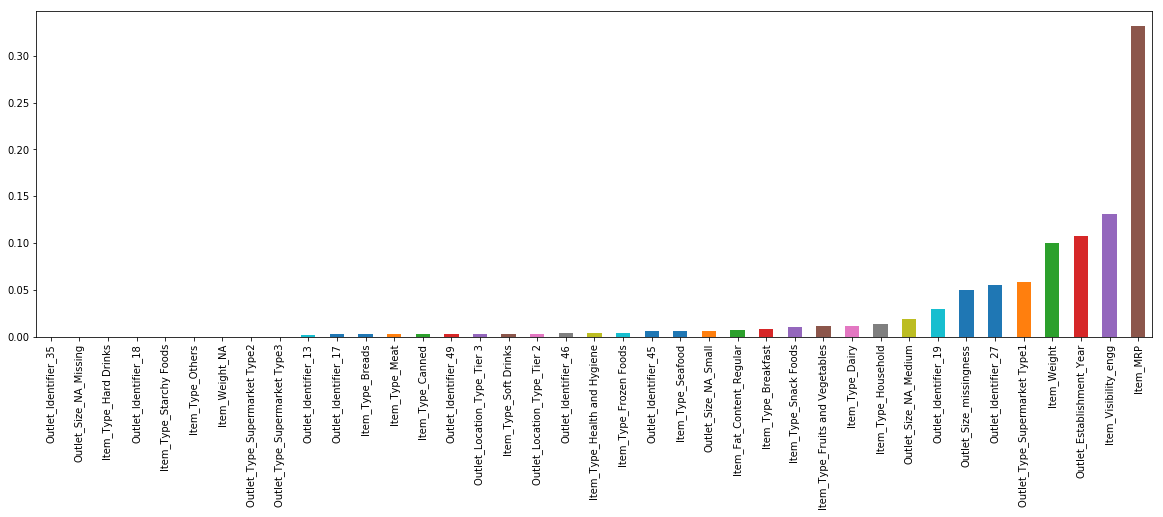

In [251]:
features = pd.Series(xgb_model.feature_importances_)
features.index = X_train_dummy.columns

# sort the features by importance
features.sort_values(ascending=True, inplace=True)

# plot
features.plot.bar(figsize=(20,6))

In [252]:
# Feature selection
from sklearn.feature_selection import SelectFromModel

In [253]:
### Feature importance by RF

In [254]:
sel_ = SelectFromModel(RandomForestRegressor(n_estimators=100))
sel_.fit(X_train_dummy, y_train)
selected_feat_rf = X_train_dummy.columns[(sel_.get_support())]
selected_feat_rf

Index(['Item_Weight', 'Item_MRP', 'Outlet_Establishment_Year',
       'Item_Visibility_engg', 'Outlet_Identifier_27',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type3'],
      dtype='object')

In [255]:
features_xgb = features.sort_values(ascending=False).head(7)

In [256]:
unCommon_features = [i for i in selected_feat_rf if i not in features_xgb]

In [257]:
unCommon_features

['Outlet_Type_Supermarket Type3']

### recursive feature elimination. (RFE)

In [258]:
from sklearn.feature_selection import RFE



In [259]:
## Lets select the top 30 features
sel_ = RFE(RandomForestRegressor(n_estimators=100), n_features_to_select=30)
sel_.fit(X_train_dummy, y_train)

RFE(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
  n_features_to_select=30, step=1, verbose=0)

In [260]:
selected_feat_rfe_30 = X_train_dummy.columns[(sel_.get_support())]
selected_feat_rfe_30

Index(['Item_Weight', 'Item_MRP', 'Outlet_Establishment_Year',
       'Item_Visibility_engg', 'Item_Fat_Content_Regular', 'Item_Type_Breads',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_18', 'Outlet_Identifier_19', 'Outlet_Identifier_27',
       'Outlet_Identifier_35', 'Outlet_Identifier_45', 'Outlet_Identifier_46',
       'Outlet_Identifier_49', 'Outlet_Location_Type_Tier 3',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3', 'Outlet_Size_NA_Medium',
       'Outlet_Size_NA_Missing', 'Outlet_Size_NA_Small'],
      dtype='object')

In [261]:
X_train_30 = X_train_dummy[selected_feat_rfe_30]
X_test_30 = X_test_dummy[selected_feat_rfe_30]

### Create new model after removal of unwanted features

In [262]:
rf_model = RandomForestRegressor(n_estimators= 100, max_depth=8)

rf_model.fit(X_train_30, np.log(y_train))
pred = rf_model.predict(X_train_30)

## Train set
print('rf train mse : {}'.format(mean_squared_error(y_train, np.exp(pred))))
print('rf train rmse : {}'.format(sqrt(mean_squared_error(y_train, np.exp(pred)))))
print('rf train R-sq: {}'.format(r2_score(y_train, np.exp(pred))))
print()
## Test set
pred = rf_model.predict(X_test_30)
print('rf train mse : {}'.format(mean_squared_error(y_test, np.exp(pred))))
print('rf train rmse : {}'.format(sqrt(mean_squared_error(y_test, np.exp(pred)))))
print('rf test R-sq: {}'.format(r2_score(y_test, np.exp(pred))))


rf train mse : 1118516.5420420126
rf train rmse : 1057.5994241876328
rf train R-sq: 0.6134497277439739

rf train mse : 1284373.291165746
rf train rmse : 1133.3019417462172
rf test R-sq: 0.5822329108122037


In [263]:
## There is no improvement in the model

In [264]:
# I will select 25 best features from the model
sel_25 = RFE(RandomForestRegressor(n_estimators=100), n_features_to_select=25)
sel_25.fit(X_train_dummy, y_train)

RFE(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
  n_features_to_select=25, step=1, verbose=0)

In [265]:
selected_feat_rfe_25 = X_train_dummy.columns[(sel_25.get_support())]

In [266]:
X_train_25 = X_train_dummy[selected_feat_rfe_25]
X_test_25 = X_test_dummy[selected_feat_rfe_25]

## Ordinary Least Squares using StatsModel

In [267]:
import statsmodels.api as sm

In [268]:
linear_Reg_25 = sm.OLS(y_train, X_train_25).fit()
linear_Reg_25.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     468.7
Date:                Mon, 10 Jun 2019   Prob (F-statistic):               0.00
Time:                        10:09:09   Log-Likelihood:                -64768.
No. Observations:                7670   AIC:                         1.296e+05
Df Residuals:                    7648   BIC:                         1.297e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Item_Weight                        -0.5148      3.058     -0.168      0.866      -6.510       5.480
Item_MRP                           15.5062      0.207     74.910      0.000      15.100      15.912
Outlet_Establishment_Year          -0.9540      0.048    -19.705      0.000      -1.049      -0.859
Item_Visibility_engg             -178.1465    261.919     -0.680      0.496    -691.579     335.286
Item_Fat_Content_Regular           55.7565     28.886      1.930      0.054      -0.867     112.380
Item_Type_Canned                   23.5204     53.952      0.436      0.663     -82.241     129.281
Item_Type_Dairy                   -67.1409     52.573     -1.277      0.202    -170.198      35.916
Item_Type_Frozen Foods            -42.4121     48.447     -0.875      0.381    -137.381      52.557
Item_Type_Fruits and Vegetables    14.2841     43.038      0.332      0.740     -70.083      98.651
Item_Type_Health and Hygiene      -19.5107     59.787     -0.326      0.744    -136.710      97.689
Item_Type_Household               -59.1596     49.115     -1.205      0.228    -155.437      37.118
Item_Type_Snack Foods             -14.4294     43.258     -0.334      0.739     -99.226      70.368
Item_Type_Soft Drinks             -43.3013     62.721     -0.690      0.490    -166.252      79.649
Outlet_Identifier_18              823.6110     42.714     19.282      0.000     739.881     907.341
Outlet_Identifier_19               62.1788     63.778      0.975      0.330     -62.844     187.202
Outlet_Identifier_27             1669.9835     42.316     39.464      0.000    1587.032    1752.935
Outlet_Identifier_35               75.8952     38.234      1.985      0.047       0.946     150.844
Outlet_Identifier_45             -195.8215     54.874     -3.569      0.000    -303.389     -88.254
Outlet_Identifier_46              -87.4144     38.242     -2.286      0.022    -162.379     -12.450
Outlet_Type_Supermarket Type1    2022.8569     64.717     31.257      0.000    1895.994    2149.720
Outlet_Type_Supermarket Type2     823.6110     42.714     19.282      0.000     739.881     907.341
Outlet_Type_Supermarket Type3    1669.9835     42.316     39.464      0.000    1587.032    1752.935
Outlet_Size_NA_Medium              71.3551     55.300      1.290      0.197     -37.048     179.758
Outlet_Size_NA_Missing             97.3814     55.533      1.754      0.080     -11.479     206.241
Outlet_Size_NA_Small               50.6596     38.504      1.316      0.188     -24.820     126.139
==============================================================================
Omnibus:                      897.488   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2219.278
Skew:                           0.678   Prob(J

#### Here we see lots of variable show p-value of t-stat greater than 0.05, i.e the variable is statically not significant



##### Lets select 15 best features

In [269]:
sel_15 = RFE(RandomForestRegressor(n_estimators=100), n_features_to_select=15)
sel_15.fit(X_train_dummy, y_train)
selected_feat_rfe_15 = X_train_dummy.columns[(sel_15.get_support())]

In [270]:
X_train_15 = X_train_dummy[selected_feat_rfe_15]
X_test_15 = X_test_dummy[selected_feat_rfe_15]

### OLS

In [272]:
linear_Reg_15 = sm.OLS(y_train, X_train_15).fit()
linear_Reg_15.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     2954.
Date:                Mon, 10 Jun 2019   Prob (F-statistic):               0.00
Time:                        10:12:06   Log-Likelihood:                -64781.
No. Observations:                7670   AIC:                         1.296e+05
Df Residuals:                    7657   BIC:                         1.297e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Item_Weight                        -0.8250      3.053     -0.270      0.787      -6.810       5.160
Item_MRP                           15.4831      0.206     74.987      0.000      15.078      15.888
Outlet_Establishment_Year          -0.8994      0.042    -21.395      0.000      -0.982      -0.817
Outlet_Size_missingness           -31.3788     35.644     -0.880      0.379    -101.250      38.493
Item_Visibility_engg             -168.0126    261.660     -0.642      0.521    -680.938     344.913
Item_Fat_Content_Regular           63.5791     27.236      2.334      0.020      10.189     116.969
Item_Type_Fruits and Vegetables    36.4354     37.458      0.973      0.331     -36.992     109.863
Item_Type_Snack Foods              10.8000     37.607      0.287      0.774     -62.921      84.521
Outlet_Identifier_18              773.8740     40.420     19.146      0.000     694.639     853.109
Outlet_Identifier_19              -16.4794     80.494     -0.205      0.838    -174.270     141.311
Outlet_Identifier_27             1620.6759     40.059     40.457      0.000    1542.148    1699.203
Outlet_Type_Supermarket Type1    1922.9351     58.536     32.850      0.000    1808.189    2037.682
Outlet_Type_Supermarket Type2     773.8740     40.420     19.146      0.000     694.639     853.109
Outlet_Type_Supermarket Type3    1620.6759     40.059     40.457      0.000    1542.148    1699.203
Outlet_Size_NA_Medium              41.2940     45.118      0.915      0.360     -47.149     129.737
==============================================================================
Omnibus:                      889.651   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2195.868
Skew:                           0.673   Prob(JB):                         0.00
Kurtosis:                       5.249   Cond. No.                     5.59e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.85e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [273]:
linear_Reg_15 = sm.OLS(y_test, X_test_15).fit()
linear_Reg_15.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     333.8
Date:                Mon, 10 Jun 2019   Prob (F-statistic):          5.71e-321
Time:                        10:12:07   Log-Likelihood:                -7212.4
No. Observations:                 853   AIC:                         1.445e+04
Df Residuals:                     840   BIC:                         1.451e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Item_Weight                         0.8542      9.338      0.091      0.927     -17.475      19.183
Item_MRP                           16.1417      0.656     24.600      0.000      14.854      17.430
Outlet_Establishment_Year          -0.9403      0.132     -7.134      0.000      -1.199      -0.682
Outlet_Size_missingness           -46.9236    113.349     -0.414      0.679    -269.404     175.556
Item_Visibility_engg            -1137.1293    785.125     -1.448      0.148   -2678.167     403.908
Item_Fat_Content_Regular          -95.8947     85.127     -1.126      0.260    -262.981      71.192
Item_Type_Fruits and Vegetables    76.5968    115.609      0.663      0.508    -150.320     303.514
Item_Type_Snack Foods            -116.6512    118.542     -0.984      0.325    -349.324     116.022
Outlet_Identifier_18              856.4316    122.680      6.981      0.000     615.637    1097.227
Outlet_Identifier_19              -99.9835    245.950     -0.407      0.684    -582.732     382.765
Outlet_Identifier_27             1768.7127    124.809     14.171      0.000    1523.738    2013.687
Outlet_Type_Supermarket Type1    2019.8027    184.284     10.960      0.000    1658.092    2381.514
Outlet_Type_Supermarket Type2     856.4316    122.680      6.981      0.000     615.637    1097.227
Outlet_Type_Supermarket Type3    1768.7127    124.809     14.171      0.000    1523.738    2013.687
Outlet_Size_NA_Medium              59.5713    135.777      0.439      0.661    -206.931     326.074
==============================================================================
Omnibus:                       71.089   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.941
Skew:                           0.583   Prob(JB):                     1.49e-26
Kurtosis:                       4.410   Cond. No.                     4.91e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.42e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

    We see that our R-sq has increases as well as Adjusted R-sq, More powerfull models can be made

    Item_Weight, Item_Type_Snack Foods, Outlet_Identifier_19 show high p-value of t-stats

    I think I should not have capped the outliers of Item_visibility column.
    ============================================================================
    
    coef -0.6229 means that if Item_Weight increases by 1 unit, the predicted value of Salse decrease by 0.6229 unit.

    R-Squared - Percentage of variation the model explains

    R-sq = (1 -(SSr/SSt))

    SSr = Sum of Sq errors(prediction)
    SSt = Sum of sq errors(simplest model i.e. mean of y)
    
    Standard error is accuracy of prediction, the lower the standered error the better is the estimate

t-stat and its p-value = 


    if the p-value is below 0.05 then it means the variable is staticallt significant
    
    

## Saving the model to disk

In [274]:
# save the model to disk
import pickle
filename = 'linear_Reg_15.sav'
pickle.dump(linear_Reg_15, open(filename, 'wb'))